In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from scipy.stats import pearsonr
import sys
import os

In [2]:
# Add parent directory to path
sys.path.append(os.path.abspath(".."))
from scripts.news_utils import (
    load_news_data,
    parse_dates,
    filter_by_ticker
)

ticker = 'AMZN'
news_path = '../data/raw_analyst_ratings.csv'
stock_path = f'../data/yfinance_data/{ticker}_historical_data.csv'

In [5]:
# ------------------ Load & Preprocess News Data ------------------
df_news = load_news_data(news_path)
df_news = parse_dates(df_news)
df_news_amzn = filter_by_ticker(df_news, ticker).copy()


In [7]:
# Remove timezone for alignment
df_news_amzn = df_news_amzn.copy()
df_news_amzn['date'] = df_news_amzn['date'].dt.tz_localize(None)

print("\nAMZN News Data Info:")
print(df_news_amzn.info())


AMZN News Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 278 entries, 76177 to 76454
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   headline   278 non-null    object        
 1   url        278 non-null    object        
 2   publisher  278 non-null    object        
 3   date       278 non-null    datetime64[ns]
 4   stock      278 non-null    object        
 5   date_only  278 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 15.2+ KB
None


In [8]:
# ------------------  Sentiment Analysis ------------------
def get_sentiment(headline):
    return TextBlob(str(headline)).sentiment.polarity  # [-1.0, +1.0]

df_news_amzn.loc[:, 'sentiment'] = df_news_amzn['headline'].apply(get_sentiment)

In [9]:
# Aggregate and convert index to datetime
daily_sentiment = (
    df_news_amzn
      .groupby('date_only')['sentiment']
      .mean()
      .reset_index(name='mean_polarity')
)

# Convert 'date_only' to datetime and set as index
daily_sentiment['date_only'] = pd.to_datetime(daily_sentiment['date_only'])
daily_sentiment = daily_sentiment.set_index('date_only').sort_index()

print(f"\n{ticker} Daily Sentiment (First 5 Rows):")
print(daily_sentiment.head())



AMZN Daily Sentiment (First 5 Rows):
            mean_polarity
date_only                
2020-04-27       0.100000
2020-04-28       0.057396
2020-04-29       0.002433
2020-04-30       0.082699
2020-05-01       0.041796


In [10]:
# ------------------  Load Stock Data ------------------
df_stock = pd.read_csv(stock_path)
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock = df_stock.set_index('Date').sort_index()

# Align stock start date with earliest news date
earliest_news_date = df_news_amzn['date'].min().normalize()
df_stock = df_stock[df_stock.index >= earliest_news_date]

# Compute daily returns
df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100

print("\nAMZN Stock Data Info:")
print(df_stock.info())



AAPL Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1072 entries, 2020-04-27 to 2024-07-30
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1072 non-null   float64
 1   High          1072 non-null   float64
 2   Low           1072 non-null   float64
 3   Close         1072 non-null   float64
 4   Adj Close     1072 non-null   float64
 5   Volume        1072 non-null   int64  
 6   Dividends     1072 non-null   float64
 7   Stock Splits  1072 non-null   float64
 8   Daily_Return  1071 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 83.8 KB
None


In [11]:
# ------------------ Step 4: Correlation Analysis ------------------
# Join stock returns with daily sentiment (inner join keeps only dates that appear in both)
df_merged = (
    df_stock[['Daily_Return']]
    .join(daily_sentiment.rename(columns={'mean_polarity':'sentiment'}), how='inner')
    .dropna(subset=['Daily_Return', 'sentiment'])
)

if len(df_merged) > 1:
    correlation, p_value = pearsonr(df_merged['sentiment'], df_merged['Daily_Return'])
    print(f"\nPearson Correlation for {ticker}: {correlation:.4f} (p-value: {p_value:.4f})")
else:
    print(f"\nInsufficient data for correlation in {ticker}")


Pearson Correlation for AMZN: -0.0022 (p-value: 0.9912)


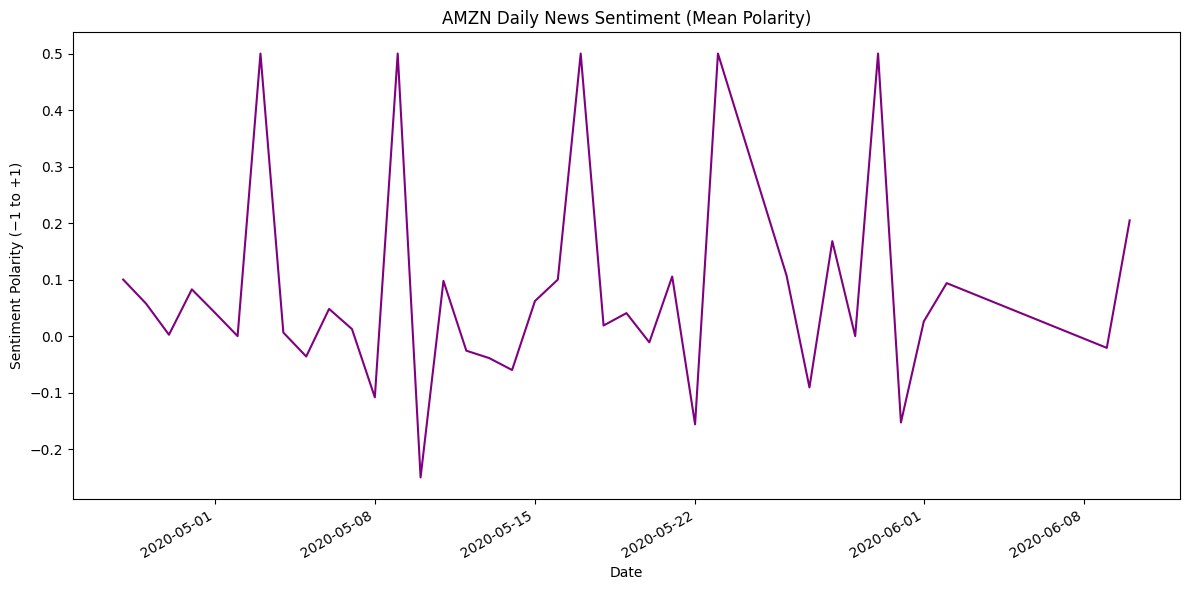

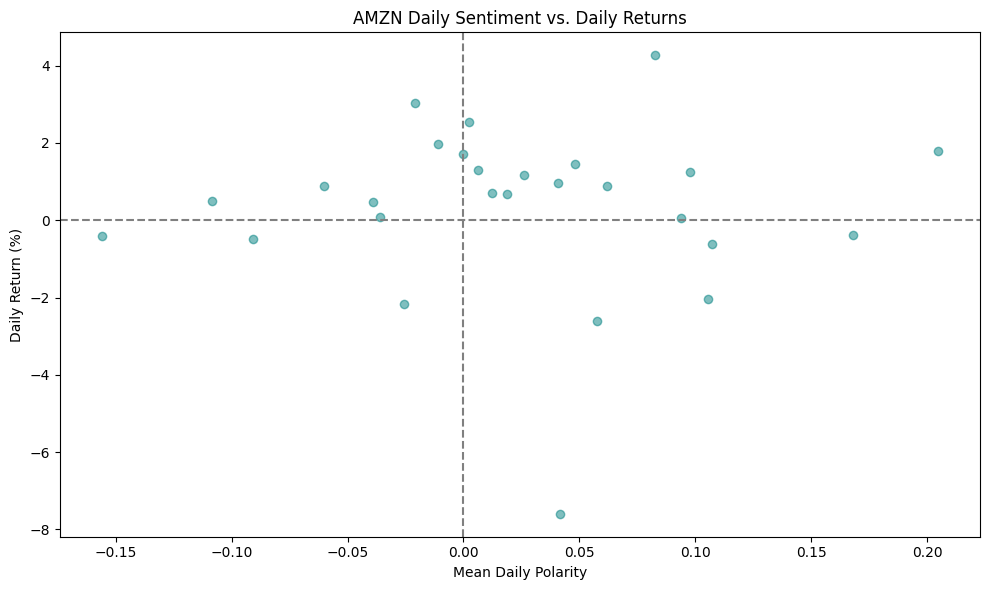

In [12]:
# 1. Plot Daily Mean Sentiment
plt.figure(figsize=(12, 6))
daily_sentiment['mean_polarity'].plot(color='purple')
plt.title(f'{ticker} Daily News Sentiment (Mean Polarity)')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity (−1 to +1)')
plt.tight_layout()
plt.show()

# 2. Plot Sentiment vs. Daily Return Scatter
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['sentiment'], df_merged['Daily_Return'], alpha=0.5, color='teal')
plt.title(f'{ticker} Daily Sentiment vs. Daily Returns')
plt.xlabel('Mean Daily Polarity')
plt.ylabel('Daily Return (%)')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()